In [2]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [3]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [4]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [5]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [6]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [7]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [8]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [9]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [10]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [11]:
print(training_data_Y[0].shape)

(200,)


In [12]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [13]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [14]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [15]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [16]:
import torch.utils.data

In [82]:
# Dataset Hyper Parameters
num_epochs = 30
batch_size = 100

In [83]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [109]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_hidden_weight = 1.0
reg_weight_size = 0.01
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 32,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [8*36],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = True

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.01)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([16, 22, 25])
torch.Size([16])
torch.Size([8, 16, 25])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([288, 288])
torch.Size([288])
torch.Size([288])
torch.Size([288])
torch.Size([4, 288])
torch.Size([4])


before final outshape torch.Size([1775, 8, 36])
final outshape torch.Size([1775, 4])
torch.Size([1775, 4])


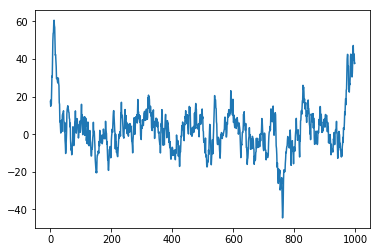

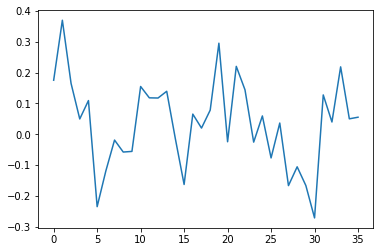

before final outshape torch.Size([1775, 8, 36])
final outshape torch.Size([1775, 4])


In [107]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
#print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/30], Iter [1/17] Loss: [----- 1.4636 = 1.4636 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [2/17] Loss: [----- 1.4352 = 1.4352 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [3/17] Loss: [----- 1.3659 = 1.3659 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [4/17] Loss: [----- 1.4061 = 1.4061 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [5/17] Loss: [----- 1.3988 = 1.3988 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [6/17] Loss: [----- 1.3513 = 1.3513 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [7/17] Loss: [----- 1.4482 = 1.4482 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [8/17] Loss: [----- 1.4358 = 1.4358 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [9/17] Loss: [----- 1.3431 = 1.3431 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [10/17] Loss: [----- 1.3108 = 1.3108 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [11/17] Loss: [----- 1.3716 = 

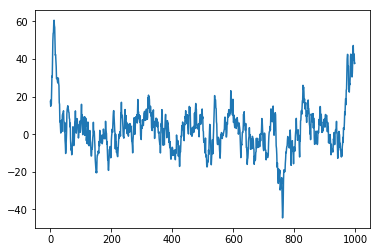

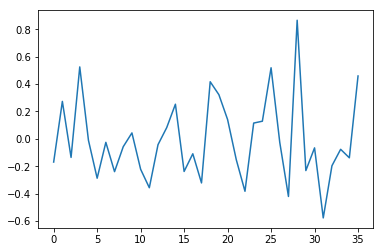

torch.Size([1775, 4])
Train Accuracy: 46 %


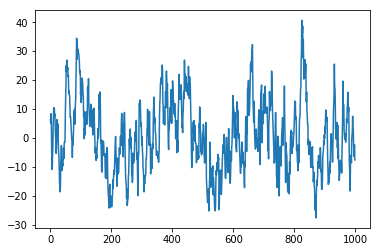

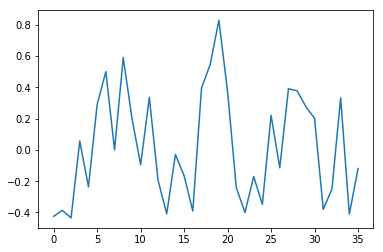

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 38 %
Epoch [2/30], Iter [1/17] Loss: [----- 1.1555 = 1.1555 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [2/17] Loss: [----- 1.1584 = 1.1584 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [3/17] Loss: [----- 1.1897 = 1.1897 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [4/17] Loss: [----- 1.2427 = 1.2427 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [5/17] Loss: [----- 1.2264 = 1.2264 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [6/17] Loss: [----- 1.1767 = 1.1767 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [7/17] Loss: [----- 1.1932 = 1.1932 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [8/17] Loss: [----- 1.1783 = 1.1783 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [9/17] Loss: [----- 1.1612 = 1.1612 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [10/17] Loss: [----- 1.2748 = 1.2748 + 1.00 * 1.6046 + 0

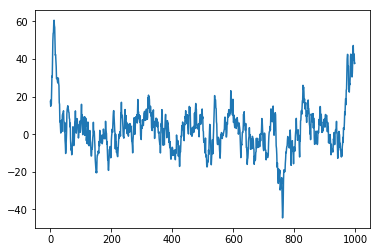

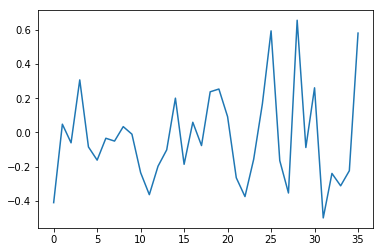

torch.Size([1775, 4])
Train Accuracy: 59 %


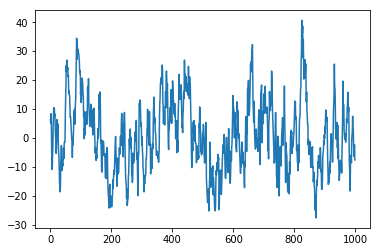

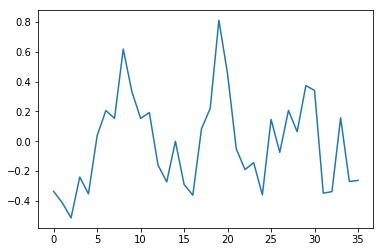

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 41 %
Epoch [3/30], Iter [1/17] Loss: [----- 1.0600 = 1.0600 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [2/17] Loss: [----- 1.0035 = 1.0035 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [3/17] Loss: [----- 1.0896 = 1.0896 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [4/17] Loss: [----- 1.0902 = 1.0902 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [5/17] Loss: [----- 1.0605 = 1.0605 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [6/17] Loss: [----- 1.1051 = 1.1051 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [7/17] Loss: [----- 1.0828 = 1.0828 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [8/17] Loss: [----- 0.9719 = 0.9719 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [9/17] Loss: [----- 1.0315 = 1.0315 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [10/17] Loss: [----- 1.0267 = 1.0267 + 1.00 * 1.6046 + 0

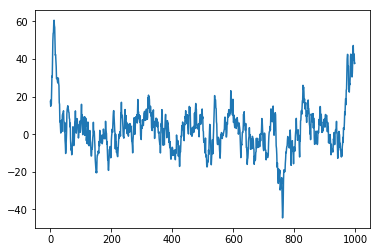

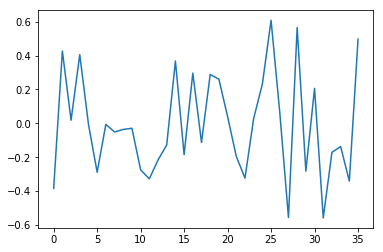

torch.Size([1775, 4])
Train Accuracy: 64 %


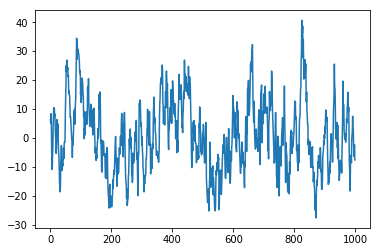

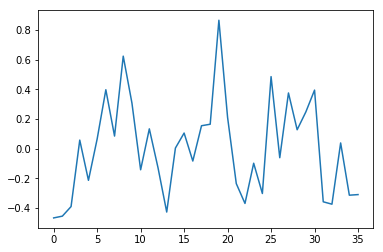

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 44 %
Epoch [4/30], Iter [1/17] Loss: [----- 0.7825 = 0.7825 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [2/17] Loss: [----- 0.9368 = 0.9368 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [3/17] Loss: [----- 0.8848 = 0.8848 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [4/17] Loss: [----- 1.0248 = 1.0248 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [5/17] Loss: [----- 0.8501 = 0.8501 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [6/17] Loss: [----- 0.8221 = 0.8221 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [7/17] Loss: [----- 0.8219 = 0.8219 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [8/17] Loss: [----- 0.9546 = 0.9546 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [9/17] Loss: [----- 0.9548 = 0.9548 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [10/17] Loss: [----- 0.8927 = 0.8927 + 1.00 * 1.6046 + 0

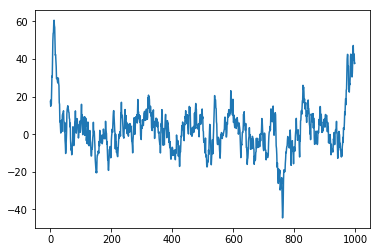

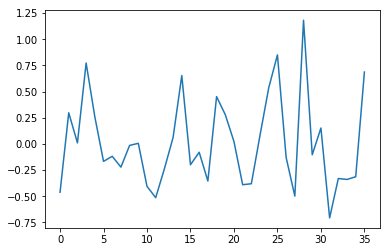

torch.Size([1775, 4])
Train Accuracy: 69 %


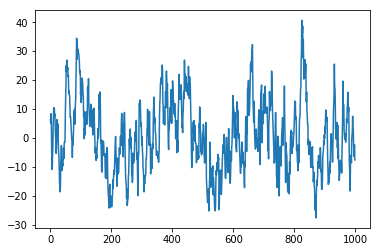

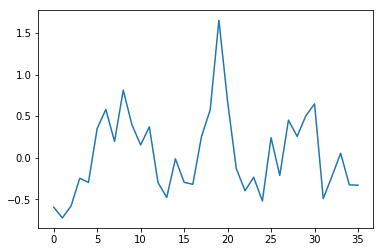

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 42 %
Epoch [5/30], Iter [1/17] Loss: [----- 0.7391 = 0.7391 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [2/17] Loss: [----- 0.8630 = 0.8630 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [3/17] Loss: [----- 0.7569 = 0.7569 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [4/17] Loss: [----- 0.8132 = 0.8132 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [5/17] Loss: [----- 0.6991 = 0.6991 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [6/17] Loss: [----- 0.8181 = 0.8181 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [7/17] Loss: [----- 0.6931 = 0.6931 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [8/17] Loss: [----- 0.7612 = 0.7612 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [9/17] Loss: [----- 0.6973 = 0.6973 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [10/17] Loss: [----- 0.7502 = 0.7502 + 1.00 * 1.6046 + 0

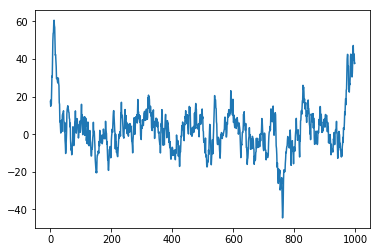

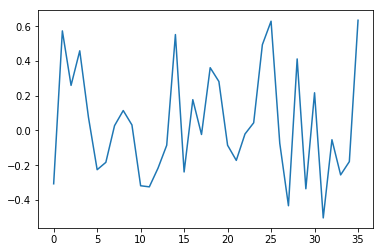

torch.Size([1775, 4])
Train Accuracy: 84 %


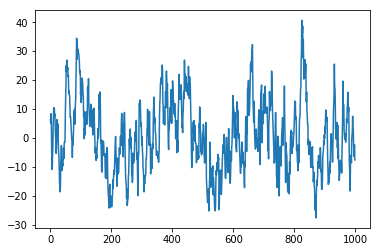

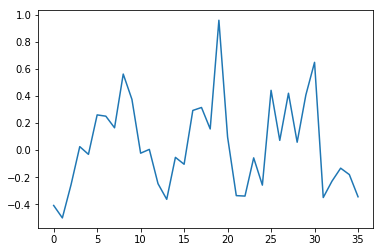

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [6/30], Iter [1/17] Loss: [----- 0.6299 = 0.6299 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [2/17] Loss: [----- 0.5970 = 0.5970 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [3/17] Loss: [----- 0.6011 = 0.6011 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [4/17] Loss: [----- 0.5720 = 0.5720 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [5/17] Loss: [----- 0.5469 = 0.5469 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [6/17] Loss: [----- 0.6292 = 0.6292 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [7/17] Loss: [----- 0.5956 = 0.5956 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [8/17] Loss: [----- 0.6370 = 0.6370 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [9/17] Loss: [----- 0.6650 = 0.6650 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [10/17] Loss: [----- 0.5797 = 0.5797 + 1.00 * 1.6046 + 0

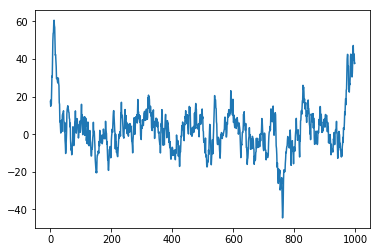

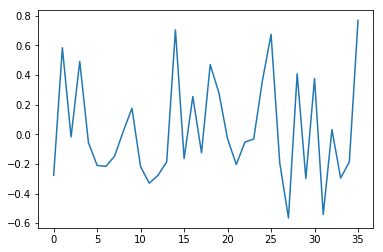

torch.Size([1775, 4])
Train Accuracy: 89 %


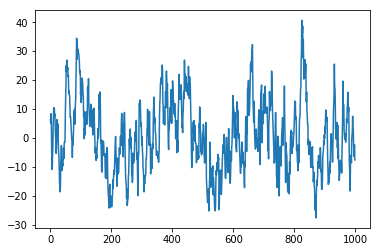

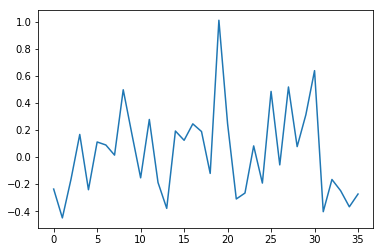

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 48 %
Epoch [7/30], Iter [1/17] Loss: [----- 0.4085 = 0.4085 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [2/17] Loss: [----- 0.5375 = 0.5375 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [3/17] Loss: [----- 0.4728 = 0.4728 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [4/17] Loss: [----- 0.4358 = 0.4358 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [5/17] Loss: [----- 0.4342 = 0.4342 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [6/17] Loss: [----- 0.5166 = 0.5166 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [7/17] Loss: [----- 0.4357 = 0.4357 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [8/17] Loss: [----- 0.4501 = 0.4501 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [9/17] Loss: [----- 0.5050 = 0.5050 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [10/17] Loss: [----- 0.4547 = 0.4547 + 1.00 * 1.6046 + 0

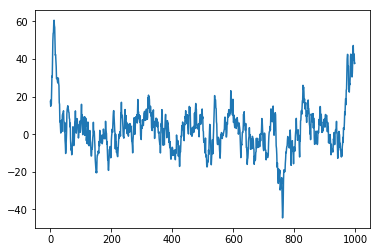

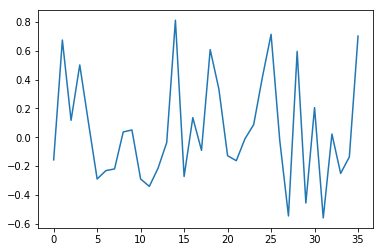

torch.Size([1775, 4])
Train Accuracy: 93 %


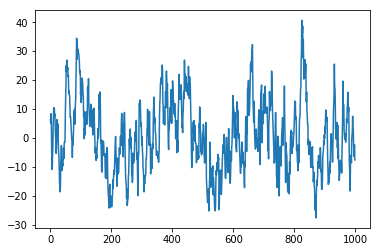

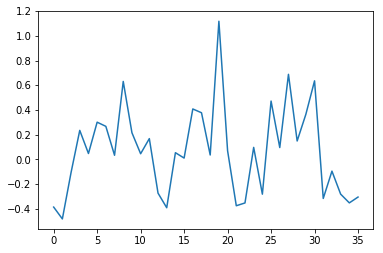

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 43 %
Epoch [8/30], Iter [1/17] Loss: [----- 0.3648 = 0.3648 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [2/17] Loss: [----- 0.3324 = 0.3324 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [3/17] Loss: [----- 0.3591 = 0.3591 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [4/17] Loss: [----- 0.2720 = 0.2720 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [5/17] Loss: [----- 0.3321 = 0.3321 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [6/17] Loss: [----- 0.3377 = 0.3377 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [7/17] Loss: [----- 0.3286 = 0.3286 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [8/17] Loss: [----- 0.3486 = 0.3486 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [9/17] Loss: [----- 0.2820 = 0.2820 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [10/17] Loss: [----- 0.3000 = 0.3000 + 1.00 * 1.6046 + 0

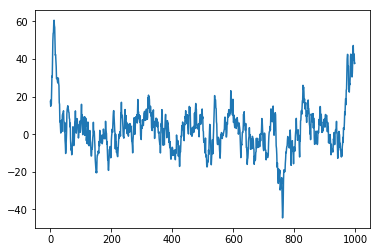

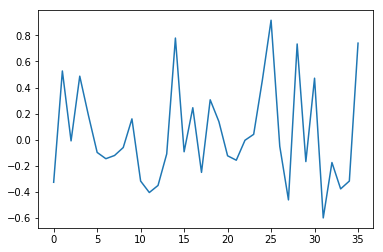

torch.Size([1775, 4])
Train Accuracy: 97 %


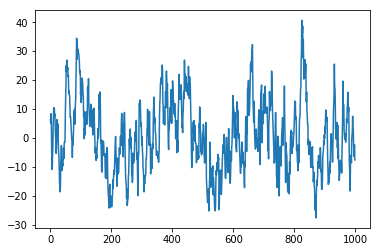

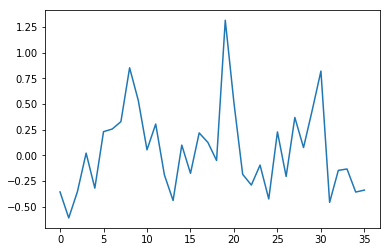

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [9/30], Iter [1/17] Loss: [----- 0.2664 = 0.2664 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [2/17] Loss: [----- 0.2044 = 0.2044 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [3/17] Loss: [----- 0.2281 = 0.2281 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [4/17] Loss: [----- 0.2129 = 0.2129 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [5/17] Loss: [----- 0.1987 = 0.1987 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [6/17] Loss: [----- 0.2240 = 0.2240 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [7/17] Loss: [----- 0.2208 = 0.2208 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [8/17] Loss: [----- 0.2227 = 0.2227 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [9/17] Loss: [----- 0.2142 = 0.2142 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [10/17] Loss: [----- 0.2438 = 0.2438 + 1.00 * 1.6046 + 0

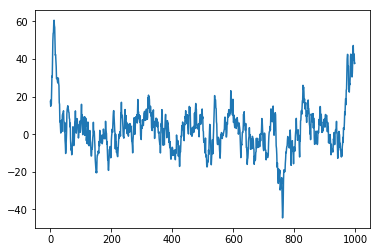

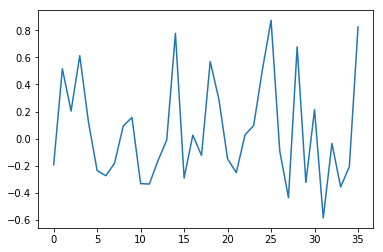

torch.Size([1775, 4])
Train Accuracy: 99 %


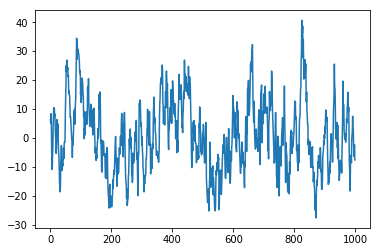

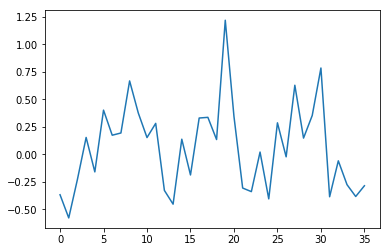

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [10/30], Iter [1/17] Loss: [----- 0.1847 = 0.1847 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [2/17] Loss: [----- 0.1536 = 0.1536 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [3/17] Loss: [----- 0.1516 = 0.1516 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [4/17] Loss: [----- 0.1650 = 0.1650 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [5/17] Loss: [----- 0.1730 = 0.1730 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [6/17] Loss: [----- 0.1741 = 0.1741 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [7/17] Loss: [----- 0.1537 = 0.1537 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [8/17] Loss: [----- 0.1155 = 0.1155 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [9/17] Loss: [----- 0.1230 = 0.1230 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [10/17] Loss: [----- 0.1324 = 0.1324 + 1.00 * 

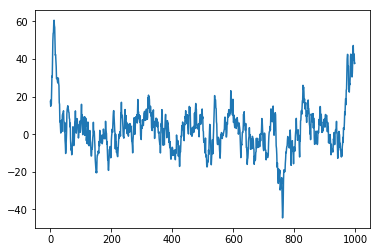

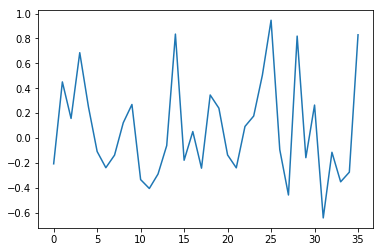

torch.Size([1775, 4])
Train Accuracy: 100 %


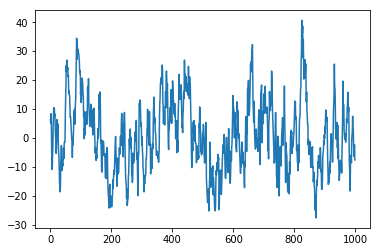

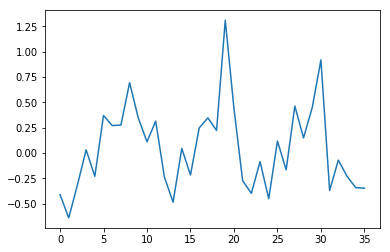

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 45 %
Epoch [11/30], Iter [1/17] Loss: [----- 0.0934 = 0.0934 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [2/17] Loss: [----- 0.1120 = 0.1120 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [3/17] Loss: [----- 0.1015 = 0.1015 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [4/17] Loss: [----- 0.1065 = 0.1065 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [5/17] Loss: [----- 0.0946 = 0.0946 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [6/17] Loss: [----- 0.0841 = 0.0841 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [7/17] Loss: [----- 0.0781 = 0.0781 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [8/17] Loss: [----- 0.0738 = 0.0738 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [9/17] Loss: [----- 0.0796 = 0.0796 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [10/17] Loss: [----- 0.1141 = 0.1141 + 1.00 * 

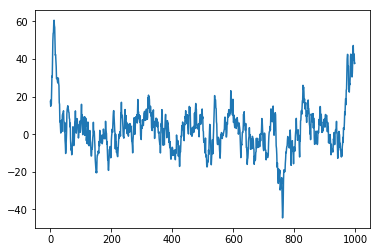

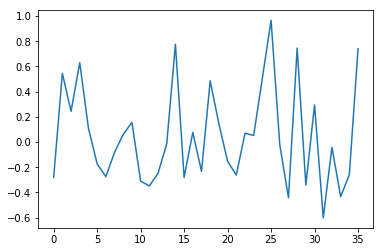

torch.Size([1775, 4])
Train Accuracy: 100 %


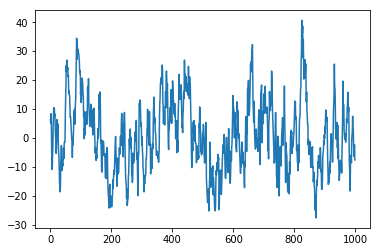

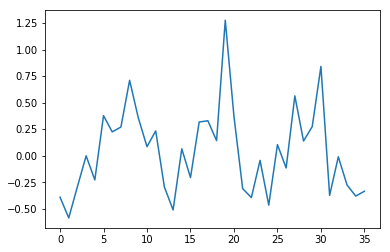

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [12/30], Iter [1/17] Loss: [----- 0.0546 = 0.0546 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [2/17] Loss: [----- 0.0639 = 0.0639 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [3/17] Loss: [----- 0.0709 = 0.0709 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [4/17] Loss: [----- 0.0598 = 0.0598 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [5/17] Loss: [----- 0.0709 = 0.0709 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [6/17] Loss: [----- 0.0610 = 0.0610 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [7/17] Loss: [----- 0.0662 = 0.0662 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [8/17] Loss: [----- 0.0517 = 0.0517 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [9/17] Loss: [----- 0.0676 = 0.0676 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [10/17] Loss: [----- 0.0699 = 0.0699 + 1.00 * 

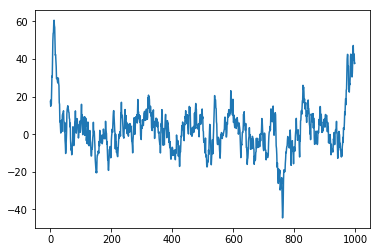

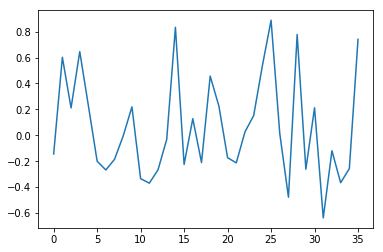

torch.Size([1775, 4])
Train Accuracy: 100 %


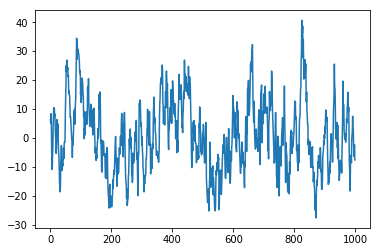

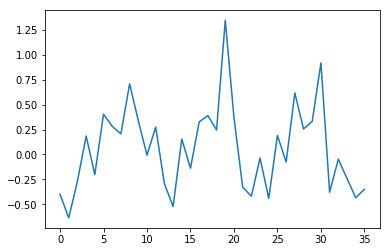

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [13/30], Iter [1/17] Loss: [----- 0.0428 = 0.0428 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [2/17] Loss: [----- 0.0496 = 0.0496 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [3/17] Loss: [----- 0.0503 = 0.0503 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [4/17] Loss: [----- 0.0497 = 0.0497 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [5/17] Loss: [----- 0.0397 = 0.0397 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [6/17] Loss: [----- 0.0343 = 0.0343 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [7/17] Loss: [----- 0.0426 = 0.0426 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [8/17] Loss: [----- 0.0517 = 0.0517 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [9/17] Loss: [----- 0.0328 = 0.0328 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [10/17] Loss: [----- 0.0422 = 0.0422 + 1.00 * 

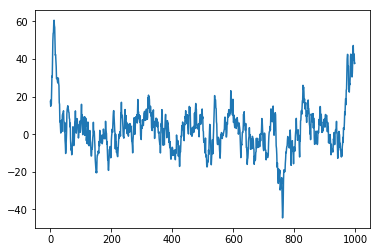

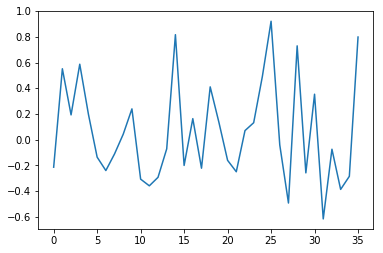

torch.Size([1775, 4])
Train Accuracy: 100 %


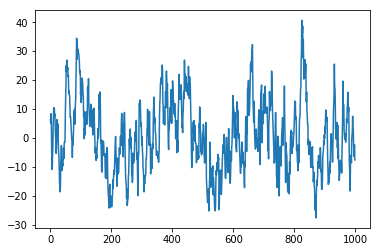

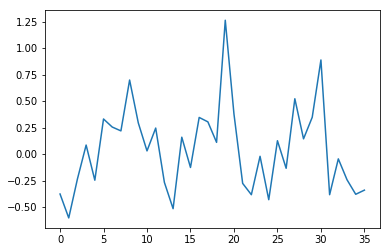

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 47 %
Epoch [14/30], Iter [1/17] Loss: [----- 0.0256 = 0.0256 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [2/17] Loss: [----- 0.0325 = 0.0325 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [3/17] Loss: [----- 0.0340 = 0.0340 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [4/17] Loss: [----- 0.0254 = 0.0254 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [5/17] Loss: [----- 0.0318 = 0.0318 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [6/17] Loss: [----- 0.0326 = 0.0326 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [7/17] Loss: [----- 0.0278 = 0.0278 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [8/17] Loss: [----- 0.0344 = 0.0344 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [9/17] Loss: [----- 0.0309 = 0.0309 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [10/17] Loss: [----- 0.0316 = 0.0316 + 1.00 * 

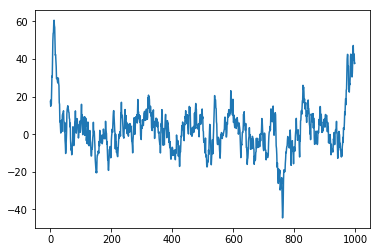

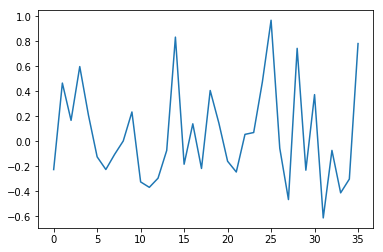

torch.Size([1775, 4])
Train Accuracy: 100 %


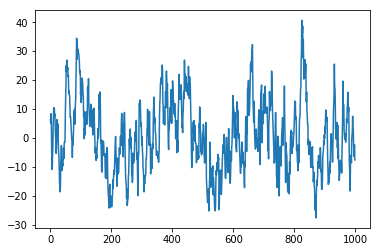

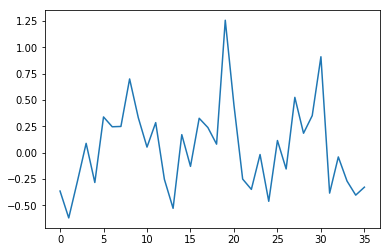

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 47 %
Epoch [15/30], Iter [1/17] Loss: [----- 0.0206 = 0.0206 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [2/17] Loss: [----- 0.0264 = 0.0264 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [3/17] Loss: [----- 0.0285 = 0.0285 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [4/17] Loss: [----- 0.0248 = 0.0248 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [5/17] Loss: [----- 0.0238 = 0.0238 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [6/17] Loss: [----- 0.0250 = 0.0250 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [7/17] Loss: [----- 0.0197 = 0.0197 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [8/17] Loss: [----- 0.0243 = 0.0243 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [9/17] Loss: [----- 0.0219 = 0.0219 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [10/17] Loss: [----- 0.0227 = 0.0227 + 1.00 * 

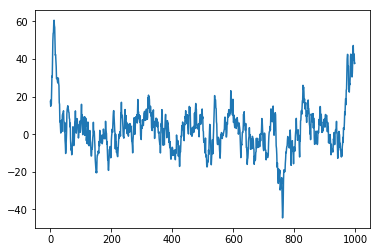

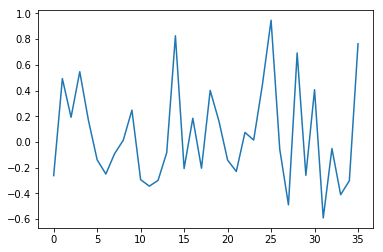

torch.Size([1775, 4])
Train Accuracy: 100 %


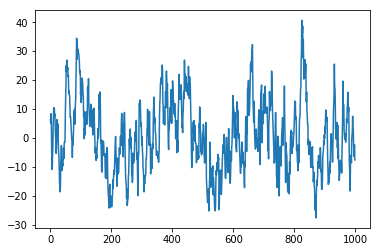

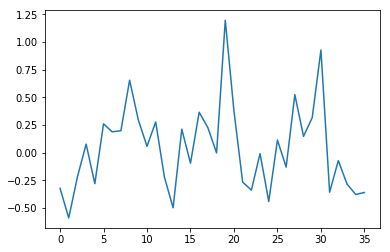

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [16/30], Iter [1/17] Loss: [----- 0.0165 = 0.0165 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [2/17] Loss: [----- 0.0205 = 0.0205 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [3/17] Loss: [----- 0.0215 = 0.0215 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [4/17] Loss: [----- 0.0203 = 0.0203 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [5/17] Loss: [----- 0.0198 = 0.0198 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [6/17] Loss: [----- 0.0196 = 0.0196 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [7/17] Loss: [----- 0.0200 = 0.0200 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [8/17] Loss: [----- 0.0202 = 0.0202 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [9/17] Loss: [----- 0.0254 = 0.0254 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [10/17] Loss: [----- 0.0267 = 0.0267 + 1.00 * 

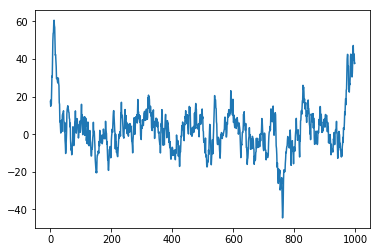

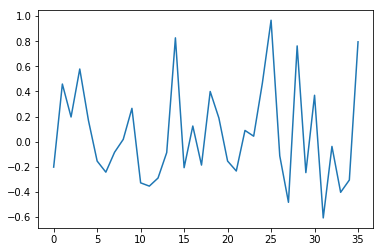

torch.Size([1775, 4])
Train Accuracy: 100 %


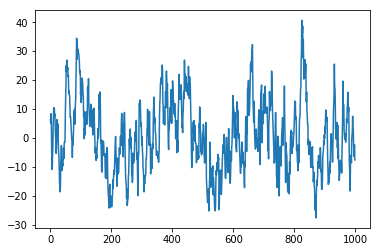

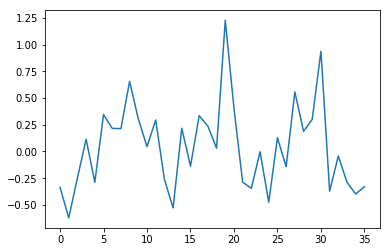

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 45 %
Epoch [17/30], Iter [1/17] Loss: [----- 0.0174 = 0.0174 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [2/17] Loss: [----- 0.0221 = 0.0221 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [3/17] Loss: [----- 0.0151 = 0.0151 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [4/17] Loss: [----- 0.0195 = 0.0195 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [5/17] Loss: [----- 0.0137 = 0.0137 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [6/17] Loss: [----- 0.0142 = 0.0142 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [7/17] Loss: [----- 0.0175 = 0.0175 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [8/17] Loss: [----- 0.0163 = 0.0163 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [9/17] Loss: [----- 0.0171 = 0.0171 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [10/17] Loss: [----- 0.0221 = 0.0221 + 1.00 * 

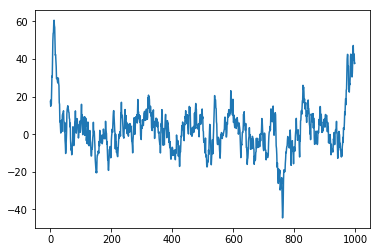

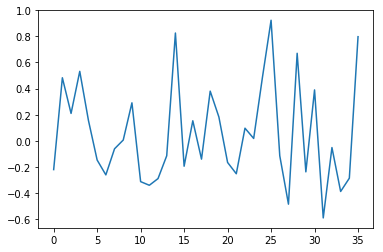

torch.Size([1775, 4])
Train Accuracy: 100 %


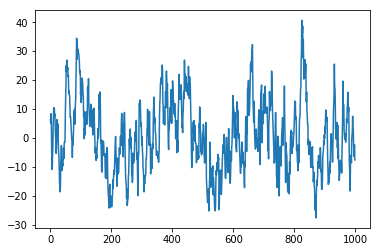

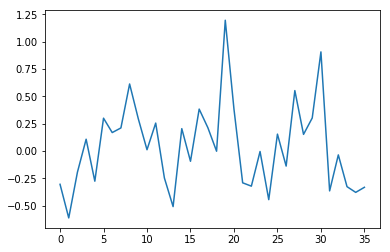

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [18/30], Iter [1/17] Loss: [----- 0.0143 = 0.0143 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [2/17] Loss: [----- 0.0127 = 0.0127 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [3/17] Loss: [----- 0.0115 = 0.0115 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [4/17] Loss: [----- 0.0122 = 0.0122 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [5/17] Loss: [----- 0.0112 = 0.0112 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [6/17] Loss: [----- 0.0121 = 0.0121 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [7/17] Loss: [----- 0.0141 = 0.0141 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [8/17] Loss: [----- 0.0115 = 0.0115 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [9/17] Loss: [----- 0.0106 = 0.0106 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [10/17] Loss: [----- 0.0116 = 0.0116 + 1.00 * 

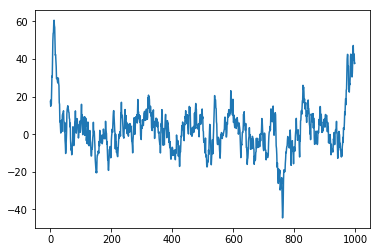

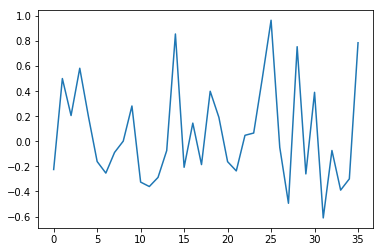

torch.Size([1775, 4])
Train Accuracy: 100 %


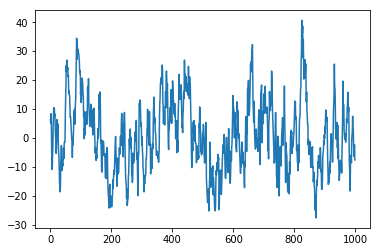

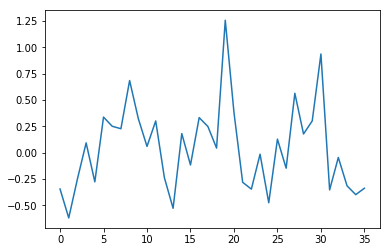

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [19/30], Iter [1/17] Loss: [----- 0.0110 = 0.0110 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [2/17] Loss: [----- 0.0087 = 0.0087 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [3/17] Loss: [----- 0.0110 = 0.0110 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [4/17] Loss: [----- 0.0104 = 0.0104 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [5/17] Loss: [----- 0.0096 = 0.0096 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [6/17] Loss: [----- 0.0113 = 0.0113 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [7/17] Loss: [----- 0.0116 = 0.0116 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [8/17] Loss: [----- 0.0145 = 0.0145 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [9/17] Loss: [----- 0.0117 = 0.0117 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [10/17] Loss: [----- 0.0093 = 0.0093 + 1.00 * 

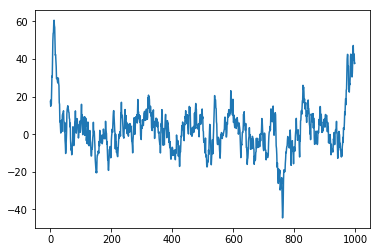

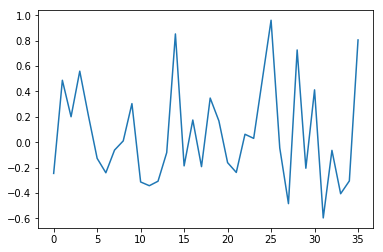

torch.Size([1775, 4])
Train Accuracy: 100 %


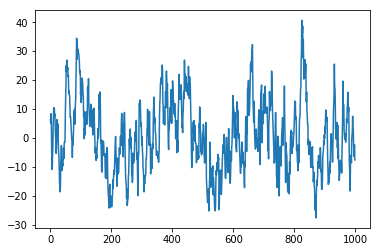

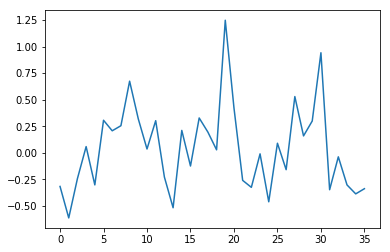

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [20/30], Iter [1/17] Loss: [----- 0.0089 = 0.0089 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [2/17] Loss: [----- 0.0083 = 0.0083 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [3/17] Loss: [----- 0.0087 = 0.0087 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [4/17] Loss: [----- 0.0098 = 0.0098 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [5/17] Loss: [----- 0.0128 = 0.0128 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [6/17] Loss: [----- 0.0086 = 0.0086 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [7/17] Loss: [----- 0.0082 = 0.0082 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [8/17] Loss: [----- 0.0076 = 0.0076 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [9/17] Loss: [----- 0.0150 = 0.0150 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [10/17] Loss: [----- 0.0081 = 0.0081 + 1.00 * 

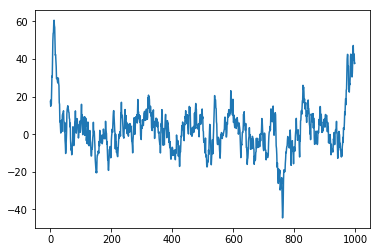

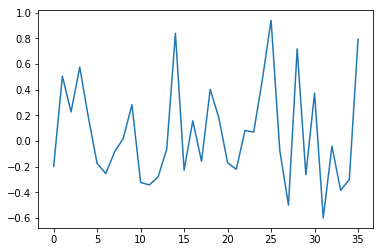

torch.Size([1775, 4])
Train Accuracy: 100 %


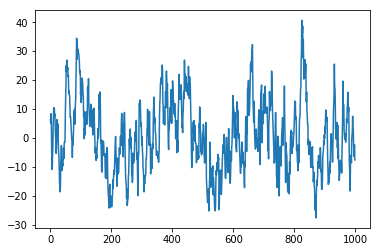

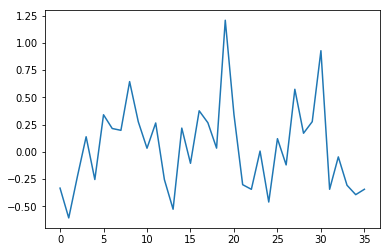

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [21/30], Iter [1/17] Loss: [----- 0.0076 = 0.0076 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [2/17] Loss: [----- 0.0083 = 0.0083 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [3/17] Loss: [----- 0.0078 = 0.0078 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [4/17] Loss: [----- 0.0084 = 0.0084 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [5/17] Loss: [----- 0.0113 = 0.0113 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [6/17] Loss: [----- 0.0142 = 0.0142 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [7/17] Loss: [----- 0.0093 = 0.0093 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [8/17] Loss: [----- 0.0072 = 0.0072 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [9/17] Loss: [----- 0.0079 = 0.0079 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [10/17] Loss: [----- 0.0104 = 0.0104 + 1.00 * 

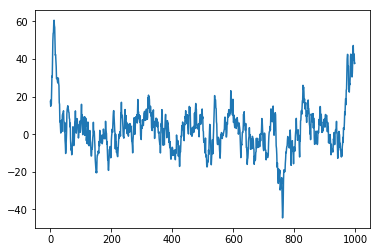

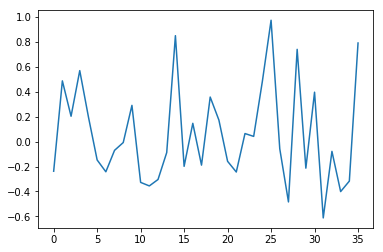

torch.Size([1775, 4])
Train Accuracy: 100 %


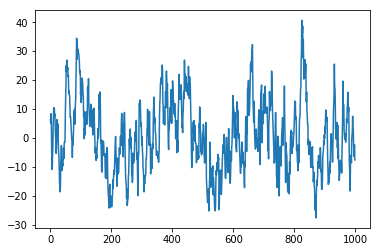

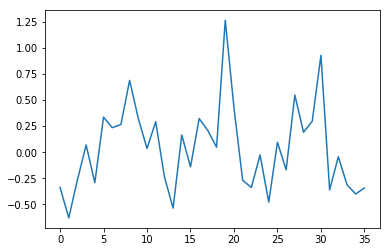

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [22/30], Iter [1/17] Loss: [----- 0.0089 = 0.0089 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [2/17] Loss: [----- 0.0075 = 0.0075 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [3/17] Loss: [----- 0.0067 = 0.0067 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [4/17] Loss: [----- 0.0072 = 0.0072 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [5/17] Loss: [----- 0.0077 = 0.0077 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [6/17] Loss: [----- 0.0084 = 0.0084 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [7/17] Loss: [----- 0.0064 = 0.0064 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [8/17] Loss: [----- 0.0067 = 0.0067 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [9/17] Loss: [----- 0.0080 = 0.0080 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [10/17] Loss: [----- 0.0064 = 0.0064 + 1.00 * 

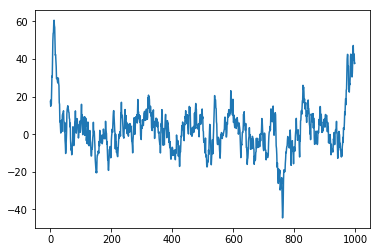

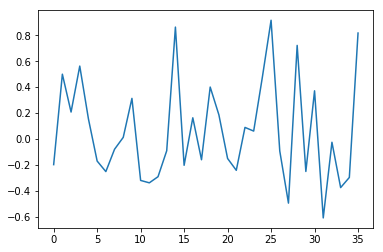

torch.Size([1775, 4])
Train Accuracy: 100 %


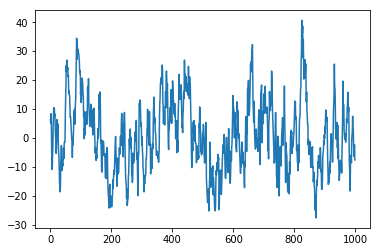

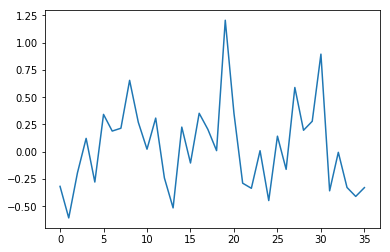

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [23/30], Iter [1/17] Loss: [----- 0.0066 = 0.0066 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [2/17] Loss: [----- 0.0062 = 0.0062 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [3/17] Loss: [----- 0.0072 = 0.0072 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [4/17] Loss: [----- 0.0102 = 0.0102 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [5/17] Loss: [----- 0.0078 = 0.0078 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [6/17] Loss: [----- 0.0064 = 0.0064 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [7/17] Loss: [----- 0.0069 = 0.0069 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [8/17] Loss: [----- 0.0066 = 0.0066 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [9/17] Loss: [----- 0.0063 = 0.0063 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [10/17] Loss: [----- 0.0076 = 0.0076 + 1.00 * 

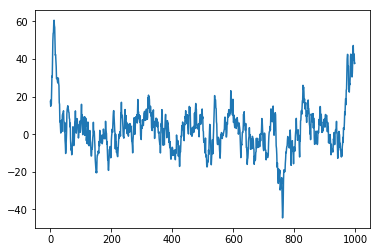

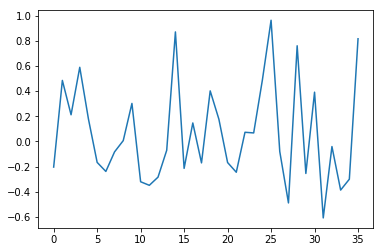

torch.Size([1775, 4])
Train Accuracy: 100 %


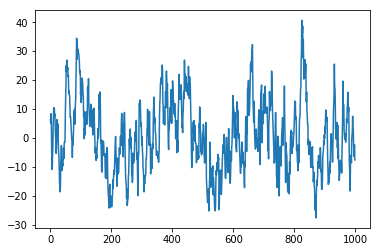

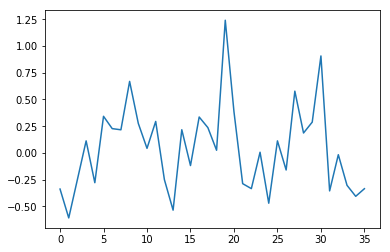

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [24/30], Iter [1/17] Loss: [----- 0.0067 = 0.0067 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [2/17] Loss: [----- 0.0068 = 0.0068 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [3/17] Loss: [----- 0.0062 = 0.0062 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [4/17] Loss: [----- 0.0070 = 0.0070 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [5/17] Loss: [----- 0.0055 = 0.0055 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [6/17] Loss: [----- 0.0065 = 0.0065 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [7/17] Loss: [----- 0.0052 = 0.0052 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [8/17] Loss: [----- 0.0052 = 0.0052 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [9/17] Loss: [----- 0.0059 = 0.0059 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [10/17] Loss: [----- 0.0048 = 0.0048 + 1.00 * 

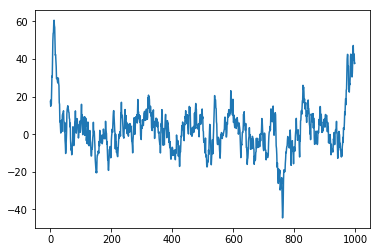

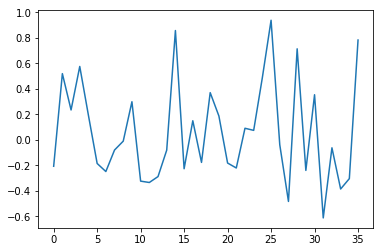

torch.Size([1775, 4])
Train Accuracy: 100 %


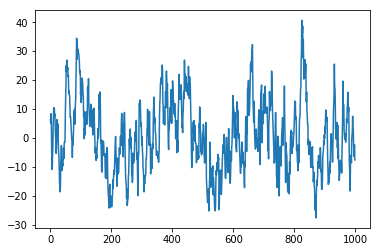

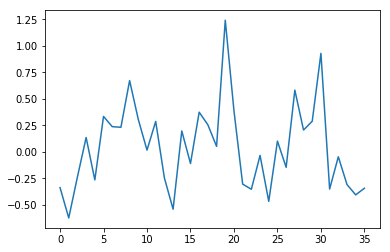

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 47 %
Epoch [25/30], Iter [1/17] Loss: [----- 0.0060 = 0.0060 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [2/17] Loss: [----- 0.0058 = 0.0058 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [3/17] Loss: [----- 0.0058 = 0.0058 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [4/17] Loss: [----- 0.0046 = 0.0046 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [5/17] Loss: [----- 0.0065 = 0.0065 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [6/17] Loss: [----- 0.0047 = 0.0047 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [7/17] Loss: [----- 0.0083 = 0.0083 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [8/17] Loss: [----- 0.0044 = 0.0044 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [9/17] Loss: [----- 0.0065 = 0.0065 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [10/17] Loss: [----- 0.0046 = 0.0046 + 1.00 * 

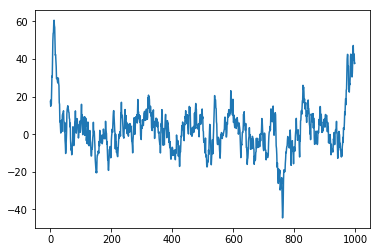

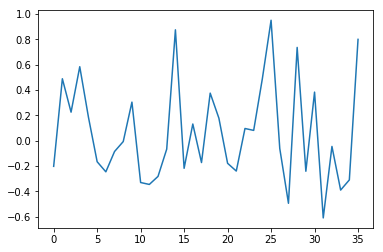

torch.Size([1775, 4])
Train Accuracy: 100 %


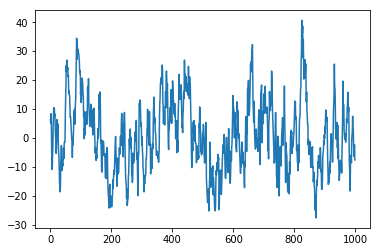

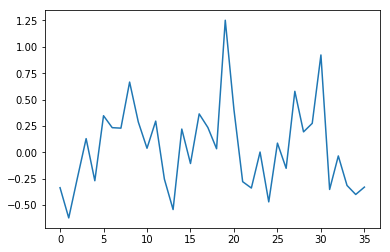

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [26/30], Iter [1/17] Loss: [----- 0.0056 = 0.0056 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [2/17] Loss: [----- 0.0050 = 0.0050 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [3/17] Loss: [----- 0.0039 = 0.0039 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [4/17] Loss: [----- 0.0054 = 0.0054 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [5/17] Loss: [----- 0.0045 = 0.0045 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [6/17] Loss: [----- 0.0050 = 0.0050 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [7/17] Loss: [----- 0.0046 = 0.0046 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [8/17] Loss: [----- 0.0061 = 0.0061 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [9/17] Loss: [----- 0.0052 = 0.0052 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [10/17] Loss: [----- 0.0041 = 0.0041 + 1.00 * 

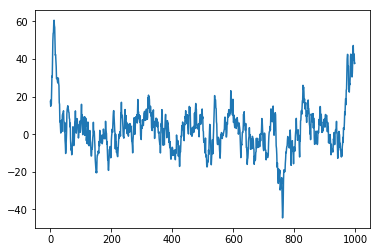

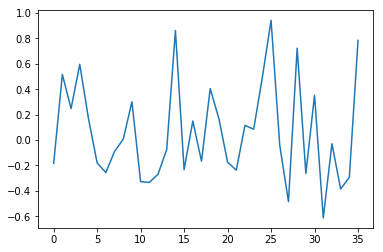

torch.Size([1775, 4])
Train Accuracy: 100 %


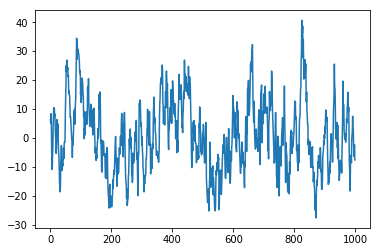

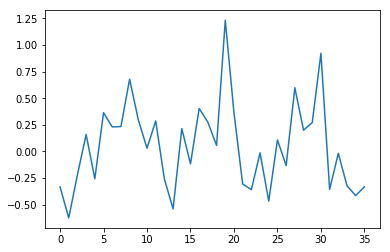

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [27/30], Iter [1/17] Loss: [----- 0.0054 = 0.0054 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [2/17] Loss: [----- 0.0052 = 0.0052 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [3/17] Loss: [----- 0.0034 = 0.0034 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [4/17] Loss: [----- 0.0049 = 0.0049 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [5/17] Loss: [----- 0.0063 = 0.0063 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [6/17] Loss: [----- 0.0061 = 0.0061 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [7/17] Loss: [----- 0.0044 = 0.0044 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [8/17] Loss: [----- 0.0052 = 0.0052 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [9/17] Loss: [----- 0.0055 = 0.0055 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [10/17] Loss: [----- 0.0031 = 0.0031 + 1.00 * 

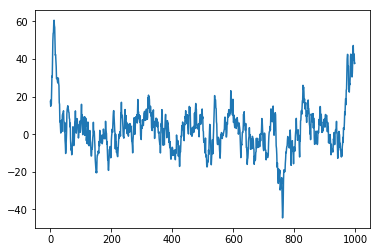

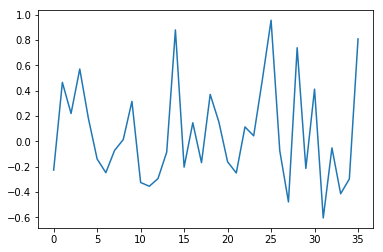

torch.Size([1775, 4])
Train Accuracy: 100 %


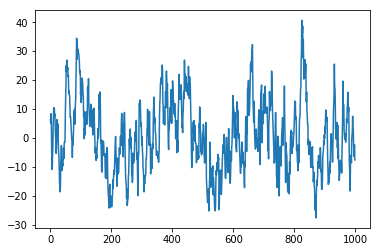

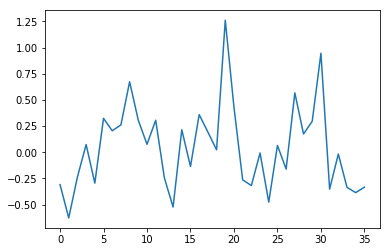

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [28/30], Iter [1/17] Loss: [----- 0.0039 = 0.0039 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [2/17] Loss: [----- 0.0041 = 0.0041 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [3/17] Loss: [----- 0.0047 = 0.0047 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [4/17] Loss: [----- 0.0040 = 0.0040 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [5/17] Loss: [----- 0.0031 = 0.0031 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [6/17] Loss: [----- 0.0037 = 0.0037 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [7/17] Loss: [----- 0.0048 = 0.0048 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [8/17] Loss: [----- 0.0044 = 0.0044 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [9/17] Loss: [----- 0.0049 = 0.0049 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [10/17] Loss: [----- 0.0042 = 0.0042 + 1.00 * 

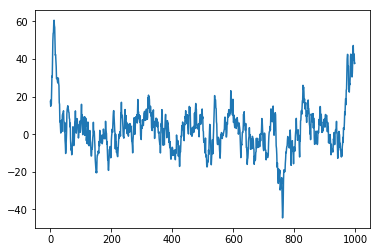

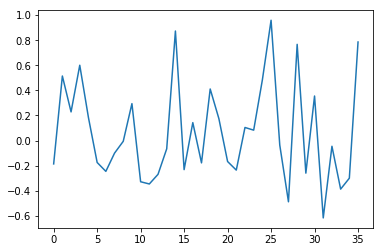

torch.Size([1775, 4])
Train Accuracy: 100 %


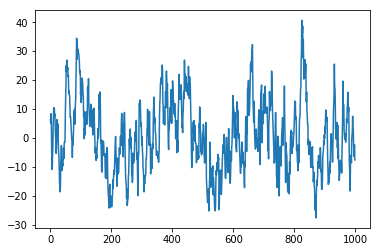

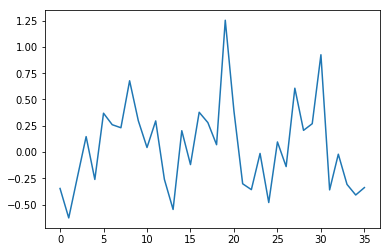

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 47 %
Epoch [29/30], Iter [1/17] Loss: [----- 0.0037 = 0.0037 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [2/17] Loss: [----- 0.0043 = 0.0043 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [3/17] Loss: [----- 0.0031 = 0.0031 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [4/17] Loss: [----- 0.0036 = 0.0036 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [5/17] Loss: [----- 0.0038 = 0.0038 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [6/17] Loss: [----- 0.0030 = 0.0030 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [7/17] Loss: [----- 0.0030 = 0.0030 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [8/17] Loss: [----- 0.0050 = 0.0050 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [9/17] Loss: [----- 0.0039 = 0.0039 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [10/17] Loss: [----- 0.0041 = 0.0041 + 1.00 * 

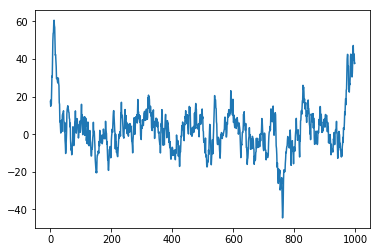

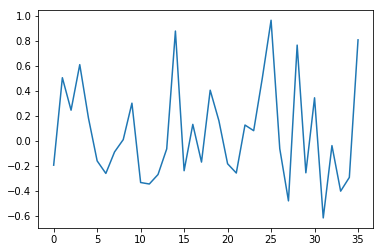

torch.Size([1775, 4])
Train Accuracy: 100 %


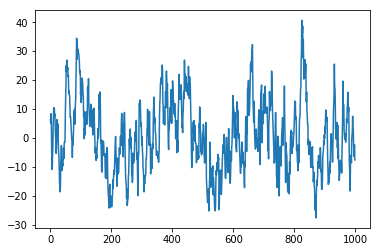

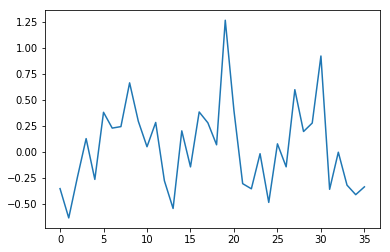

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 47 %
Epoch [30/30], Iter [1/17] Loss: [----- 0.0033 = 0.0033 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [2/17] Loss: [----- 0.0028 = 0.0028 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [3/17] Loss: [----- 0.0042 = 0.0042 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [4/17] Loss: [----- 0.0038 = 0.0038 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [5/17] Loss: [----- 0.0041 = 0.0041 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [6/17] Loss: [----- 0.0036 = 0.0036 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [7/17] Loss: [----- 0.0041 = 0.0041 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [8/17] Loss: [----- 0.0031 = 0.0031 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [9/17] Loss: [----- 0.0041 = 0.0041 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [10/17] Loss: [----- 0.0038 = 0.0038 + 1.00 * 

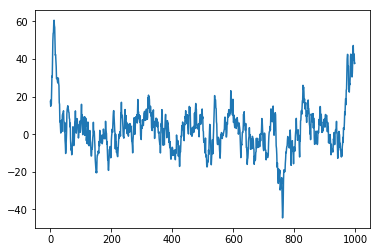

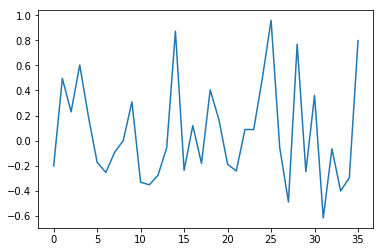

torch.Size([1775, 4])
Train Accuracy: 100 %


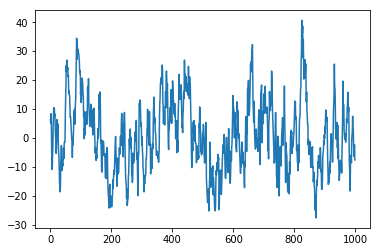

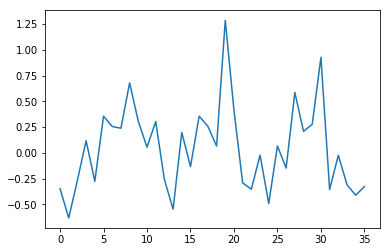

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 47 %


In [110]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        ## hidden state vanishing gradient regularizer
        #hidden_loss, size_loss = net.loss_regularizer()
        
        ## general weight l2 regularizer()
        
        loss = loss1 #+ reg_hidden_weight*hidden_loss + reg_weight_size*size_loss

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), 100)
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f + %.2f * %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0],
                 reg_hidden_weight, hidden_loss.data[0],
                 reg_weight_size, size_loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-4):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

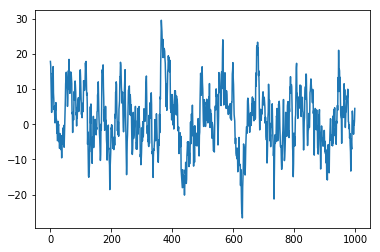

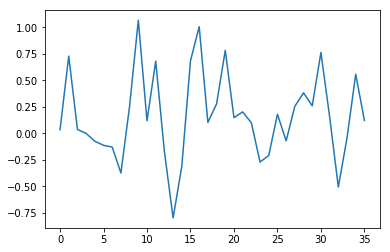

Test Accuracy of the model on the 10000 test images: 45 %


In [112]:

# Test the Model
net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
images = Variable(torch.Tensor(rnn_test_data_X))
labels = torch.LongTensor(rnn_test_data_Y)
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100.0 * int(correct) / float(total)))

In [ ]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)